In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware', 'sci.crypt']


newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

In [3]:
# LDA -> LatentDirichletAllocation 
# hyper-parameter : max_iter, learning_method, n_jobs, random_state

from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components=10, # 추출할 topic의 수 
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0, 
                                learning_method='online', 
                                n_jobs= -1, # 사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)
print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.903 0.007 0.027 0.008 0.007 0.008 0.007 0.007 0.007 0.018]
#Sum of topic weights of documents: [0.087 0.083 0.085 0.115 0.115 0.126 0.098 0.072 0.07  0.148]
#shape of topic word distribution: (10, 2000)


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words -1: -1]]))
        
    print()
    
print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, objective, caltech, moral
Topic #1: image, file, graphics, files, ftp, available, software, use, data, mail
Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite
Topic #3: article, com, just, don't, like, i'm, nntp, university, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, bit, ibm, bus, know, windows, thanks, card, university
Topic #6: host, gov, nntp, posting, university, distribution, nasa, ___, world, com
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, message, faq, mail, pgp, des, group, uni, ripem
Topic #9: god, people, don't, jesus, believe, just, does, say, think, know



n_components: 6, perplexity: 1058.260
n_components: 7, perplexity: 1055.111
n_components: 8, perplexity: 1018.328
n_components: 9, perplexity: 1017.749
n_components: 10, perplexity: 1028.686
n_components: 11, perplexity: 1033.398
n_components: 12, perplexity: 1032.112
n_components: 13, perplexity: 1038.642
n_components: 14, perplexity: 1038.627
n_components: 15, perplexity: 1044.712


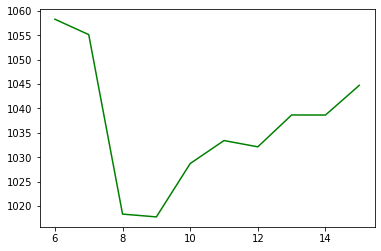

n_components with minimum perplexity: 9


In [5]:
import matplotlib.pyplot as plt 

%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior=0.1, doc_topic_prior=1.0):
    iter_num = []
    per_value = []
    
    for i in range(start, end+1):
        lda = LatentDirichletAllocation(n_components=i, 
                                        max_iter=max_iter, 
                                        topic_word_prior=topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior, 
                                        learning_method='batch', 
                                        n_jobs=-1, 
                                        random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv) # 언어모델 평가 지표 : 낮을수록 좋다.
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:.3f}')
        print()
        
    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))
print("n_components with minimum perplexity:", show_perplexity(review_cv, start=6, end=15))

In [6]:
lda = LatentDirichletAllocation(n_components=9, 
                                max_iter=20, 
                                topic_word_prior=0.1, 
                                doc_topic_prior=1.0, 
                                learning_method='batch', 
                                n_jobs=-1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names(), 10)

Topic #0: image, available, file, ftp, mail, data, files, information, graphics, internet
Topic #1: nasa, space, gov, ___, center, orbit, earth, research, jpl, 1993
Topic #2: com, keith, morality, caltech, sgi, objective, article, think, moral, don't
Topic #3: jesus, god, just, com, know, article, john, good, don't, bible
Topic #4: people, god, don't, does, think, say, believe, just, way, evidence
Topic #5: drive, scsi, card, disk, ide, hard, controller, bus, bit, drives
Topic #6: space, access, article, year, launch, just, digex, like, henry, toronto
Topic #7: key, encryption, clipper, chip, government, com, keys, security, use, public
Topic #8: com, posting, nntp, host, university, article, i'm, know, thanks, ibm



### Gensim

In [7]:
!pip install --upgrade gensim

  Using cached gensim-4.1.2-cp39-cp39-win_amd64.whl (24.0 MB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Using cached Cython-0.29.23-cp39-cp39-win_amd64.whl (1.7 MB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24


In [8]:
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer 

cachedStopWords = stopwords.words('english')

RegTok = RegexpTokenizer("[\w']{3,}")
english_stops = set(cachedStopWords)

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    words = [word for word in tokens if (word not in english_stops) and (len(word) >2)]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

In [18]:
from gensim.corpora.dictionary import Dictionary 

dictionary = Dictionary(texts)
print("#Number of initial unique words in documents:", len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
# sklearn의 CountVectorizer == gensim의 doc2bow
# BOW 형태로 변환해준다. 
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [17]:
len(texts) == corpus.__len__()

True

In [19]:
# gensim.models -> LdaModel
# https://radimrehurek.com/gensim/models/ldamodel.html

# passes -> iteration
# id2word -> dictionary

from gensim.models import LdaModel 

num_topics = 10 
passes = 5

%time model = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, num_topics=num_topics, random_state=7)

Wall time: 16.6 s


In [20]:
# 각토큰에 대한 비중이 출력됨.
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [21]:
print('#topic distribution of the first document:', model.get_document_topics(corpus)[0])

#topic distribution of the first document: [(0, 0.72576743), (8, 0.2699525)]


In [25]:
# !pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\EonKim\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040248       1        1  22.655056
5      0.065989  0.123620       2        1  14.524261
9      0.072132  0.092872       3        1  12.987644
7      0.138319  0.043609       4        1  11.025351
4     -0.021828  0.007495       5        1   9.289051
6      0.072783 -0.094709       6        1   9.119544
3      0.027374 -0.054949       7        1   8.491726
0     -0.040785 -0.129975       8        1   4.529069
2      0.005361 -0.091972       9        1   4.053713
1     -0.182145  0.063760      10        1   3.324586, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3751.000000  3751.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.405374  1672.313912  Topic10  -5.1558   0.1471
789          sci    53.231140   309.451543  Topic10  -5.3463   1.6437
602   university    56.828056  1487.187360  Topic10  -5.2810   0.1392
294         time    55.733510  1187.633077  Topic10  -5.3004   0.3447
315       better    54.159329   564.475433  Topic10  -5.3291   1.0599

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006271      128
1359      2  0.068985      128
1359      3  0.037628      128
1359      4  0.877990      128
153       1  0.057462     1993
...     ...       ...      ...
343       8  0.022401    years
343       9  0.005600    years
343      10  0.121336    years
704       3  0.991471      zoo
705       3  0.984020  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

In [26]:
# 토픽 응집도 계산 -> CoherenceModel
# https://radimrehurek.com/gensim/models/coherencemodel.html

from gensim.models import CoherenceModel
# u_mass 를 사용할 때에는 model, corpus가 필요함.
# c로 시작하는 척도를 사용할 때에는 model, texts가 필요함.
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')

coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplextity: -7.035, coherence: -1.701
num_topics: 7, perplextity: -7.023, coherence: -1.735
num_topics: 8, perplextity: -7.023, coherence: -1.547
num_topics: 9, perplextity: -7.007, coherence: -1.891
num_topics: 10, perplextity: -6.996, coherence: -1.888
num_topics: 11, perplextity: -7.027, coherence: -2.164
num_topics: 12, perplextity: -7.019, coherence: -2.018
num_topics: 13, perplextity: -7.025, coherence: -2.255
num_topics: 14, perplextity: -7.020, coherence: -2.082
num_topics: 15, perplextity: -7.019, coherence: -2.521


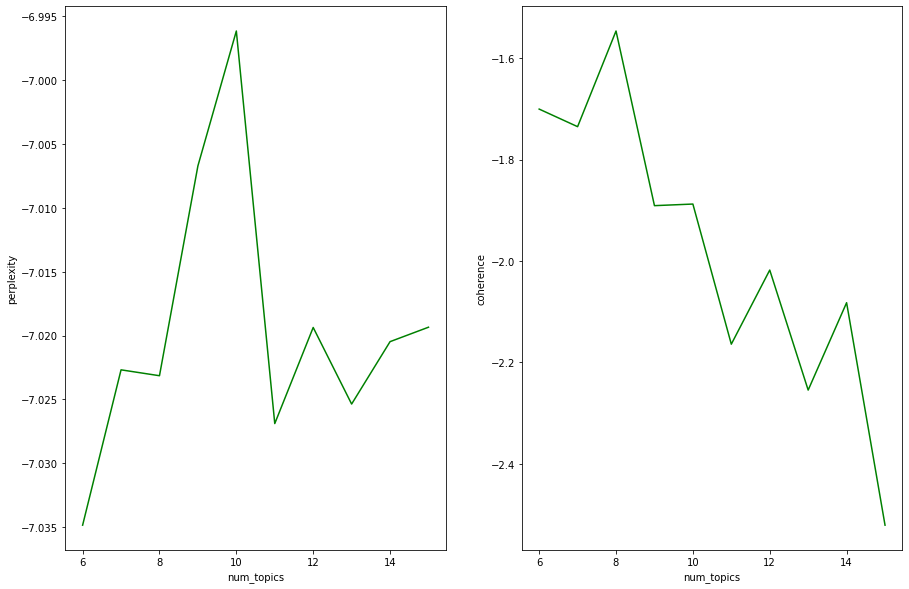

In [29]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []
    
    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                         chunksize=1000, num_topics=i, random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplextity: {pv:.3f}, coherence: {cv:.3f}')
        
        
    fig, aes = plt.subplots(figsize=(15, 10),nrows=1, ncols=2)
    
    for (ax, graph, name) in zip(aes, [per_value, coh_value], ['perplexity', 'coherence']):
        ax.plot(iter_num, graph, 'g-')
        ax.set_xlabel('num_topics')
        ax.set_ylabel(name)
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

In [31]:
import os
import pandas as pd

In [34]:
df = pd.read_csv('petition_sampled.csv')

In [38]:
df.iloc[[2],:]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt 
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer = tokenizer, 
                      max_df=0.5, min_df=5, 
                      max_features=1000)

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [41]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=15, n_jobs=-1, random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(', '.join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))
print_top_words(lda, vec.get_feature_names(), 15)

Wall time: 44.1 s
Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 자신, 피해, 환자, 가족, 범죄, 정말, 대한
Topic #1: 북한, 한국, 우리, 대통령, 정부, 미국, 대한민국, 국민, 일본, 국가, 문제, 생각, 우리나라, 중국
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 저희, 출산
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 사찰, 게임, 생각, 이용, 소음, 사람, 나이, 사회
Topic #4: 국민, 대통령, 정부, 나라, 정책, 주택, 부동산, 서민, 사람, 지금, 아파트, 문재인, 세금, 대한민국
Topic #5: 일자리, 기업, 정부, 근무, 생각, 근로자, 지원, 임금, 최저임금, 정책, 시간, 직원, 사람, 고용
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 생각, 반대, 청와대, 세금, 제도, 동의, 정치, 투표, 대통령
Topic #7: 대한, 관리, 내용, 조사, 판결, 관련, 공사, 업무, 판사, 사실, 기관, 해당, 확인, 결과
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 의료, 보험료, 기초, 건강, 공단
Topic #10: 여성, 공무원, 사회, 남성, 생각, 의무, 남자, 대한민국, 여자, 행정, 군대, 사람, 나라, 국가
Topic #11: 경찰, 범죄, 국민, 위해, 대한민국, 조직, 불법, 만행, 사건, 수사, 범죄자, 부정부패, 검찰, 빨갱이
Topic #12: 차량, 사고, 처벌, 사건, 신고, 주차, 증거, 기사, 경우, 택시, 안전, 이명박, 발생, 운전
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래, 시장, 규제, 계획, 주식, 담배, 흡연, 사업, 개인
Topic #14: 사람, 지역, 회사, 저희

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt 
trend_data = pd.DataFrame(pet_topics, columns=['Topic' + str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.460206,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.000447,0.000447,0.000447,2017-08


In [49]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5,-5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.031905,0.010507,0.036244,0.025885,0.106103
2017-09,0.042780,0.024993,0.037086,0.021294,0.044257
2017-10,0.089529,0.053818,0.050834,0.033566,0.097228
2017-11,0.046314,0.046327,0.216338,0.041019,0.049564
2017-12,0.056824,0.026315,0.066910,0.050224,0.078167


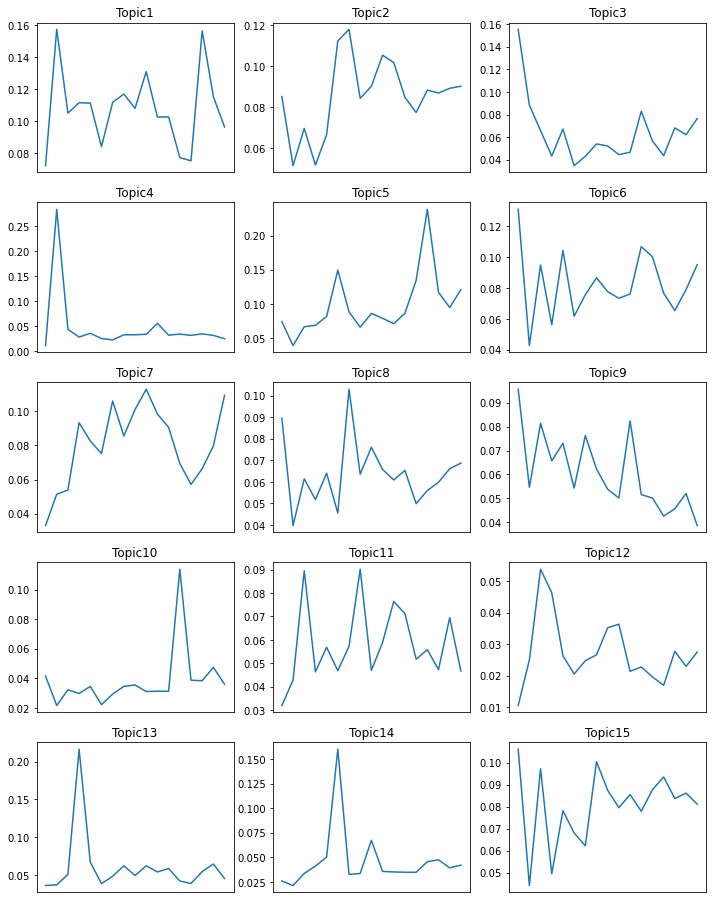

In [50]:
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline 

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16))
for col, ax in zip(trend.columns.tolist(), axes.ravel()):
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()